# LAB 02:  Advanced Feature Engineering in Keras 

**Learning Objectives**

* Setup up the environment
* Locate the dataset files
* Define features, the label, and default values
* Create an input pipeline using tf.data
* Create ML models using Keras
* Visualize the DNN model layers
* Train the model and visualize the loss curve
* Incorporate temporal features
* Incorporate Geolocation Features with Bucketization and Feature Crosses
* Feature Cross Temporal Features
* Create and test a prediction model


## Introduction 

In this notebook, we use Keras to build a taxi fare price prediction model and utilize feature engineering to improve the fare amount prediction for NYC taxi cab rides. 

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solution/feateng-solution_bqml.ipynb). **NOTE TO SELF**:  UPDATE HYPERLINK. 

## Set up environment variables and load necessary libraries

In [ ]:
import os, json, math
import numpy as np
import datetime
import shutil
from sklearn.model_selection import train_test_split #Just temporarily used to split the data
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)
 #Just temporarily used to split the data
PROJECT = "your-gcp-project-here" # REPLACE WITH YOUR PROJECT NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

NBUCKETS = 10  # for feature crossing

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BUCKET"] = PROJECT # DEFAULT BUCKET WILL BE PROJECT ID
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

if PROJECT == "your-gcp-project-here":
  print("Don't forget to update your PROJECT name! Currently:", PROJECT)

## The Source Dataset 

The Taxi Fare datasetfor this lab is 106,545 rows and has been pre-processed and split for use in this lab.  Note that the dataset is same as used in the Big Query feature engineering labs.  The fare_amount is the target, the continuous value we’ll train a model to predict.  
 

## Locate the CSV files

We will start with the CSV files that have already been pre-processed and split.

#### **Exercise**:  **RUN** the cell below show the list of files in the directory.  You should see three .csv files.

In [ ]:
# TO DO
# Objective:  Locate the CSV files

!ls -l ../../data/*.csv

## Define Features, the Label, and Default Values

Typically, you will use a two step proces to build the pipeline. Step one is to define our columns of data, which column we're predicting for, and the default values.  Step 2 is to define two functions - a function to define the features and label you want to use and a function to load the training data.


#### **Exercise**:  Correct the cell below that define our columns of data.  Hint:  Use all the columns.  Remember that we are predicting 'fare_amount'.

What does the default value ['na'] denote?

In [ ]:
# TO DO.
# Objective:  Define Features, the Label, and Default Values

CSV_COLUMNS  = [
    
                                            ]
LABEL_COLUMN = 
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

In [2]:
# SOLUTION
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

## Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

 

#### **Exercise**:    **RUN** the cell below.  What is happening with the features 'pickup_datetime' and 'key'?
Note that if we were to include the pickup_datetime at this point, we would receive the following error:  UnimplementedError: Cast string to float is not supported [Op:Cast] name: Cast/.  Since pickup_datetime is a string and not a float, we will use another option to include it in the data model.

In [3]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

## Model 1:  Create the Baseline DNN Model in Keras

Now let's build the Deep Neural Network (DNN) model in Keras using the functional API. Unlike the sequential API, we will need to specify the input and hidden layers.  Note that we are creating a linear regression baseline model with no feature engineering. Recall that a baseline model is a solution to a problem without applying any machine learning techniques.

#### **Exercise**:   Correct the cell below that creates, compiles, and fits a Keras model.

In [236]:
## TO DO - ## Build a simple Keras DNN using its Functional API.  
# In this model, exclude the pickup_datetime as a feature column.

# Root mean square error
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Build the DNN model 
def build_dnn_model():
    NUMERIC_COLS = [      ]

    # input layer    
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    
     # feature_columns
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation=' ', name='  ')(h2)
    model = tf.keras.models.Model(inputs, output)
    
    
    # compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model


print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

In [4]:
# SOLUTION
# Objctive: Create ML models using Keras

# Root mean square error
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Build the DNN model 
def build_dnn_model():
    NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    
     # feature_columns
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    
    
    # compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model


print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
passenger_count (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_latitude (InputLayer)    [(None,)]            0                                            
________________________________________________________

## Visualize the DNN model layers


#### **Exercise**:   **RUN** the cell to plot the model summary.

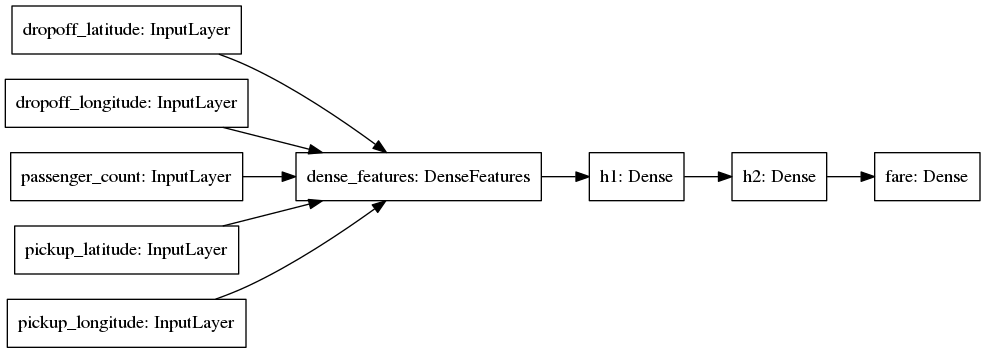

In [5]:
# Objective: Visualize the DNN model layers

tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

#### **Exercise**:   **RUN** the cell below to train the model.

In [7]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 68188 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 10  # how many times to evaluate
NUM_EVAL_EXAMPLES = 17000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/10
1065/1065 [==============================] - 8s 8ms/step - loss: 92.9827 - rmse: 9.0507 - mse: 92.9827 - val_loss: 111.1220 - val_rmse: 10.5310 - val_mse: 111.1220
Epoch 2/10
1065/1065 [==============================] - 7s 7ms/step - loss: 97.0862 - rmse: 9.2612 - mse: 97.0862 - val_loss: 110.8260 - val_rmse: 10.5170 - val_mse: 110.8260
Epoch 3/10
1065/1065 [==============================] - 11s 10ms/step - loss: 93.5706 - rmse: 9.0776 - mse: 93.5706 - val_loss: 110.2876 - val_rmse: 10.4915 - val_mse: 110.2876
Epoch 4/10
1065/1065 [==============================] - 8s 8ms/step - loss: 96.3939 - rmse: 9.1668 - mse: 96.3939 - val_loss: 110.9852 - val_rmse: 10.5245 - val_mse: 110.9852
Epoch 5/10
1065/1065 [==============================] - 9s 8ms/step - loss: 95.7627 - rmse: 9.1831 - mse: 95.7627 - val_loss: 111.1682 - val_rmse: 10.5332 - val_mse: 111.1682
Epoch 6/10
1065/1065 [==============================] - 11s 10ms/step - loss: 96.5834 - rmse: 9.1813 - mse: 96.5834 - val_l

### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

#### **Exercise**:   **RUN** the cell below to show the model's loss curves.

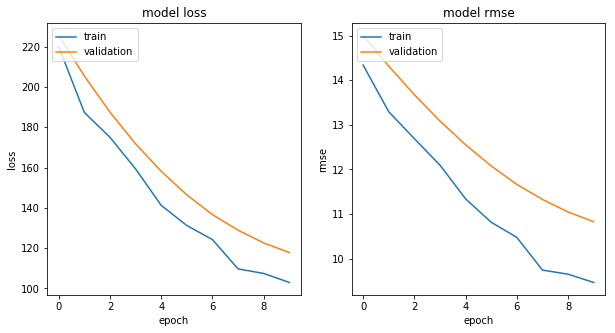

In [9]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Model 2:  Incorporate a Temporal Feature

We now incorporate the temporal feature pickup_datetime.  As noted earlier, pickup_datetime is a string and we will need to handle this within the model.  First, you will include the pickup_datetime as a feature and then you will need to modify the model to handle our string feature.

#### **Exercise**:   Correct the cell below to include the pickup_datetime and exclude the key feature. 

In [ ]:
# TO DO
# Objective:  Incorporating a temporal feature

def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

In [18]:
#SOLUTION

def features_and_labels(row_data):
    for unwanted_col in ['key']: #Keep pickup_datetime
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

#### **Exercise**:   The cell below creates and compiles a second DNN model.  Correct the function def build_dnn_model() to allow for strings and numeric values to be included in the input layer.

In [212]:
#TO DO.  HINT:  THE CODE IS MISISNG SEVERAL PARAMETERS. ALSO, REVIEW THE VARIABLE "NUMERIC_COLS".
# Create ML models using Keras

# Root mean square error
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Build the DNN model 
def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = [    ]
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    
   # input layer 
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in 
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in 
    })
    
     # feature_column
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in 
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    
   # Compile model 
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

In [19]:
#SOLUTION 

# Root mean square error
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Build the DNN model 
def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    
   # input layer 
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in STRING_COLS
    })
    
     # feature_column
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    
   # Compile model 
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

['pickup_datetime']
{'dropoff_longitude', 'passenger_count', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude'}
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
passenger_count (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_datetime (InputLayer)    [

#### **Exercise**:   **RUN** the cell to show the model plot.

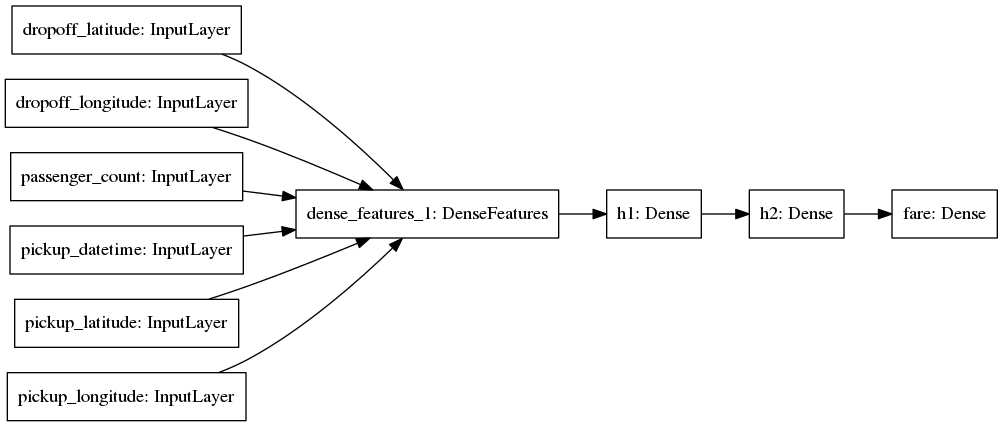

In [12]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

#### **Exercise**:   Correct the cell below to train the model.

In [ ]:
# TO DO - CORRECT

TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 68188 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 10  # how many times to evaluate
NUM_EVAL_EXAMPLES = 17000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(     )



In [20]:
#SOLUTION
# Objective:  Train the model and visualize the loss curve

TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 68188 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 10  # how many times to evaluate
NUM_EVAL_EXAMPLES = 17000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)



Epoch 1/10
1065/1065 [==============================] - 11s 10ms/step - loss: 139.4549 - rmse: 10.0133 - mse: 139.4550 - val_loss: 110.6973 - val_rmse: 10.5042 - val_mse: 110.6973
Epoch 2/10
1065/1065 [==============================] - 8s 8ms/step - loss: 96.3974 - rmse: 9.1930 - mse: 96.3975 - val_loss: 111.7019 - val_rmse: 10.5506 - val_mse: 111.7018
Epoch 3/10
1065/1065 [==============================] - 9s 9ms/step - loss: 96.5345 - rmse: 9.2413 - mse: 96.5346 - val_loss: 114.1148 - val_rmse: 10.6635 - val_mse: 114.1148
Epoch 4/10
1065/1065 [==============================] - 8s 8ms/step - loss: 97.3123 - rmse: 9.2514 - mse: 97.3124 - val_loss: 113.5905 - val_rmse: 10.6390 - val_mse: 113.5904
Epoch 5/10
1065/1065 [==============================] - 9s 8ms/step - loss: 93.7976 - rmse: 9.1242 - mse: 93.7977 - val_loss: 110.7955 - val_rmse: 10.5087 - val_mse: 110.7955
Epoch 6/10
1065/1065 [==============================] - 10s 9ms/step - loss: 100.0953 - rmse: 9.3555 - mse: 100.0953 - v

#### **Exercise**:   **RUN** the cell below to show the model's loss curves.

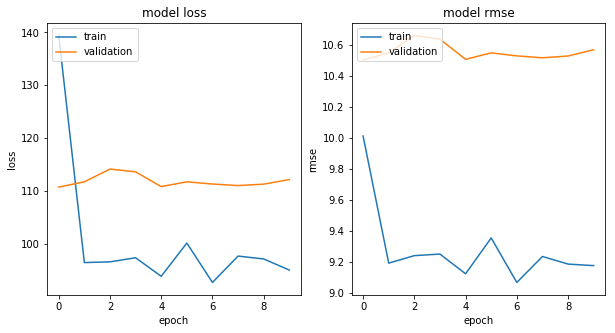

In [21]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Model 3: Incorporate Geolocation Features with Bucketization and Feature Crosses

We now feature engineer the geolocation or spatial features.  We create two new "geo" function for our model.  We create a function called "euclidean" to initialize our geolocation parameters.  We then create a function called transform.   The transform function passes our numerical and string columns features as inputs to the model, scales geolocation features, then creates the Euclian distance as a transformed variable with the geolocation features. Lastly, we bucketize the latitude and longitude features.
  

#### **Exercise**:   **RUN** the cell to create the features_and_labels function and the load_dataset function.

In [22]:
def features_and_labels(row_data):
    for unwanted_col in ['key']: #Keep pickup_datetime
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

#### Geolocation/Coordinate Features:

The pick-up and drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled. As such, we need to teach the model the Euclidean distance between the pick-up and drop-off points.

Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates. In our training data set, we restricted our data points to only pickups and drop offs within NYC. New York city has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85.

The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pickup and drop off points. We can do this using the Euclidean Distance, which is the straight-line distance between any two coordinate points.

#### **Exercise**: Correct the code to include the euclidean feature column - then run the cell.  

In [266]:
# TO DO 
# Objective:  Incorporate geolocation features and bucketization

#/***************************************************************************************************************
## Add transformations
def euclidean(params):
            = params
            = lon2 - lon1
            = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

#/***************************************************************************************************************
def transform(inputs, NUMERIC_COLS, STRING_COLS):
    print("BEFORE TRANSFORMATION")
    print("INPUTS:", inputs.keys())
    
    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']
    
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }

    # scale the lat, lon values to be in 0, 1
    if True:
        for lon_col in ['pickup_longitude', 'dropoff_longitude']:  # in range -70 to -78
            transformed[lon_col] = tf.keras.layers.Lambda(
                lambda x: (x+78)/8.0, 
                name='scale_{}'.format(lon_col)
            )(inputs[lon_col])
        for lat_col in ['pickup_latitude', 'dropoff_latitude']: # in range 37 to 45
            transformed[lat_col] = tf.keras.layers.Lambda(
                lambda x: (x-37)/8.0, 
                name='scale_{}'.format(lat_col)
            )(inputs[lat_col])

    # add Euclidean distance. Doesn't have to be accurate calculation because NN will calibrate it
    if True:
        transformed['euclidean'] = tf.keras.layers.Lambda(euclidean, name='euclidean')([
            inputs['               '],
            inputs['               '],
            inputs['               '],
            inputs['               ']
        ])
        feature_columns['euclidean'] = tf.feature_column.numeric_column('euclidean')
    
    if True:
        # https://buganizer.corp.google.com/issues/135479527
        # featurecross lat, lon into nxn buckets, then embed
        nbuckets = NBUCKETS
        latbuckets = np.linspace(0, 1, nbuckets).tolist()
        lonbuckets = np.linspace(0, 1, nbuckets).tolist()
        b_plat = tf.feature_column.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
        b_dlat = 
        b_plon = 
        b_dlon = 
        ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
        dloc = 
        pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4 )
        feature_columns['pickup_and_dropoff'] = tf.feature_column.embedding_column(pd_pair, 100)

    print("AFTER TRANSFORMATION")
    print("TRANSFORMED:", transformed.keys())
    print("FEATURES", feature_columns.keys())   
    
    return transformed, feature_columns


In [ ]:
# SOLUTION

## Add transformations
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)


def transform(inputs, NUMERIC_COLS, STRING_COLS):
    print("BEFORE TRANSFORMATION")
    print("INPUTS:", inputs.keys())
    
    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']
    
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
    # scale the lat, lon values to be in 0, 1
    if True:
        for lon_col in ['pickup_longitude', 'dropoff_longitude']:  # in range -70 to -78
            transformed[lon_col] = tf.keras.layers.Lambda(
                lambda x: (x+78)/8.0, 
                name='scale_{}'.format(lon_col)
            )(inputs[lon_col])
        for lat_col in ['pickup_latitude', 'dropoff_latitude']: # in range 37 to 45
            transformed[lat_col] = tf.keras.layers.Lambda(
                lambda x: (x-37)/8.0, 
                name='scale_{}'.format(lat_col)
            )(inputs[lat_col])

    # add Euclidean distance. Doesn't have to be accurate calculation because NN will calibrate it
    if True:
        transformed['euclidean'] = tf.keras.layers.Lambda(euclidean, name='euclidean')([
            inputs['pickup_longitude'],
            inputs['pickup_latitude'],
            inputs['dropoff_longitude'],
            inputs['dropoff_latitude']
        ])
        feature_columns['euclidean'] = tf.feature_column.numeric_column('euclidean')
    
    if True:
        # https://buganizer.corp.google.com/issues/135479527
        # featurecross lat, lon into nxn buckets, then embed
        nbuckets = NBUCKETS
        latbuckets = np.linspace(0, 1, nbuckets).tolist()
        lonbuckets = np.linspace(0, 1, nbuckets).tolist()
        b_plat = tf.feature_column.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
        b_dlat = tf.feature_column.bucketized_column(feature_columns['dropoff_latitude'], latbuckets)
        b_plon = tf.feature_column.bucketized_column(feature_columns['pickup_longitude'], lonbuckets)
        b_dlon = tf.feature_column.bucketized_column(feature_columns['dropoff_longitude'], lonbuckets)
        ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
        dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
        pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4 )
        feature_columns['pickup_and_dropoff'] = tf.feature_column.embedding_column(pd_pair, 100)

    print("AFTER TRANSFORMATION")
    print("TRANSFORMED:", transformed.keys())
    print("FEATURES", feature_columns.keys())   
    return transformed, feature_columns


#### **Exercise**: **Run** the cell to build and compile the DNN model.  

In [23]:
#DNN MODEL
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in STRING_COLS
    })
    
    # transforms
    transformed, feature_columns = transform(inputs, NUMERIC_COLS, STRING_COLS)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    
   # Compile model 
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

model = build_dnn_model()
print(model.summary())

['pickup_datetime']
{'dropoff_longitude', 'passenger_count', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude'}
BEFORE TRANSFORMATION
INPUTS: dict_keys(['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime'])
AFTER TRANSFORMATION
TRANSFORMED: dict_keys(['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'euclidean'])
FEATURES dict_keys(['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_and_dropoff', 'euclidean'])
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
_____________________________________________________________________________________________

#### **Exercise**:   **RUN** the cell to show the model plot.

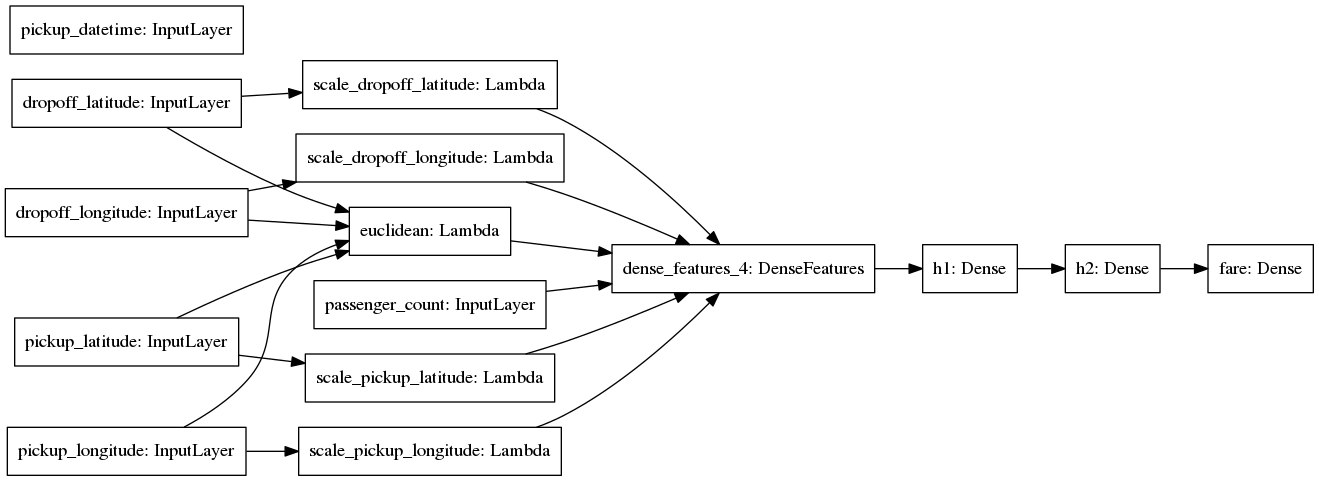

In [24]:
#visualize model
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

#### **Exercise**:   **RUN** the cell below to train the model.

In [25]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 68188 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 10  # how many times to evaluate
NUM_EVAL_EXAMPLES = 17000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)



Epoch 1/10
1065/1065 [==============================] - 29s 27ms/step - loss: 102.4577 - rmse: 9.3954 - mse: 102.4577 - val_loss: 100.9975 - val_rmse: 10.0373 - val_mse: 100.9975
Epoch 2/10
1065/1065 [==============================] - 24s 22ms/step - loss: 67.1251 - rmse: 7.6080 - mse: 67.1251 - val_loss: 47.8538 - val_rmse: 6.8968 - val_mse: 47.8538
Epoch 3/10
1065/1065 [==============================] - 29s 27ms/step - loss: 27.6473 - rmse: 4.3773 - mse: 27.6473 - val_loss: 27.0482 - val_rmse: 5.1666 - val_mse: 27.0482
Epoch 4/10
1065/1065 [==============================] - 29s 27ms/step - loss: 27.9718 - rmse: 4.1903 - mse: 27.9718 - val_loss: 28.4815 - val_rmse: 5.3086 - val_mse: 28.4815
Epoch 5/10
1065/1065 [==============================] - 29s 27ms/step - loss: 21.4883 - rmse: 3.8781 - mse: 21.4883 - val_loss: 26.3443 - val_rmse: 5.0996 - val_mse: 26.3443
Epoch 6/10
1065/1065 [==============================] - 24s 23ms/step - loss: 30.0626 - rmse: 4.2483 - mse: 30.0626 - val_los

#### **Exercise**:   **RUN** the cell to show the model plot.

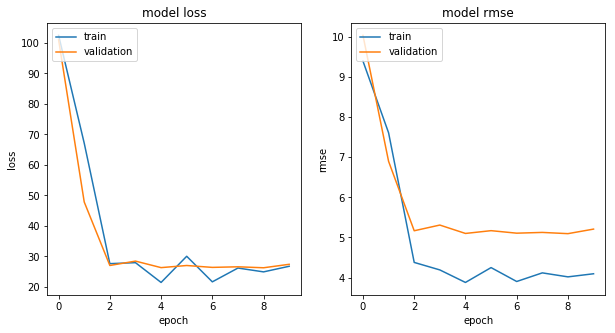

In [26]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

**Run** the cell.  Note the fare price at this geolocation and pickup_datetime.

In [27]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]), 
    'pickup_datetime': tf.convert_to_tensor(['2019-06-03 04:21:29 UTC'], dtype=tf.string),
}, steps=1)

array([[8.301081]], dtype=float32)

## Model 4:  Feature Cross Temporal Features

We now feature engineer the temporal feature **pickup_datetime**.  We create a function to parse the **pickup_datetime** feature and a **for loop** to test it.  

#### **Exercise**:   **RUN** the cells  below to create the parse_datetime function and to test the for loop.

In [28]:
def parse_datetime(s):
    if type(s) is not str:
        s = s.numpy().decode('utf-8') # if it is a Tensor
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")

In [29]:
for s in ['2012-07-05 14:18:00 UTC']:
    print(s)
    for ts in [parse_datetime(s), parse_datetime(tf.constant(s))]: # as string, as tensor
        print(ts.weekday())
        DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
        print(DAYS[ts.weekday()])

2012-07-05 14:18:00 UTC
3
Wed
3
Wed


### Review the DNN model below.  
1.  What two functions were added?  
2.  What new variable was initialized?
3.  What new "IF" statements were added?  Why?

#### **Exercise**:   **RUN** the cell to create the final model.

In [30]:
## Add transformations
#/****************************************************************************************************************
DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def get_dayofweek(s):
    ts = parse_datetime(s)
    return DAYS[ts.weekday()]

@tf.function
def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in
    )


#/****************************************************************************************************************

def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

def transform(inputs, NUMERIC_COLS, STRING_COLS):
    print("BEFORE TRANSFORMATION")
    print("INPUTS:", inputs.keys())
    
    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']
    
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
      # hour of day from timestamp of form '2010-02-08 09:17:00+00:00'
    if True:
        transformed['hourofday'] = tf.keras.layers.Lambda(
            lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
            name='hourofday'
        )(inputs['pickup_datetime'])
        feature_columns['hourofday'] = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_identity('hourofday', num_buckets=24))

    if False:
        # https://buganizer.corp.google.com/issues/137795281
        # day of week is hard because there is no TensorFlow function for date handling
        transformed['dayofweek'] = tf.keras.layers.Lambda(
            lambda x: dayofweek(x),
            name='dayofweek_pyfun'
        )(inputs['pickup_datetime'])
        transformed['dayofweek'] = tf.keras.layers.Reshape((), name='dayofweek')(transformed['dayofweek'])
        feature_columns['dayofweek'] = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
              'dayofweek', vocabulary_list = DAYS))

    
    # scale the lat, lon values to be in 0, 1
    if True:
        for lon_col in ['pickup_longitude', 'dropoff_longitude']:  # in range -70 to -78
            transformed[lon_col] = tf.keras.layers.Lambda(
                lambda x: (x+78)/8.0, 
                name='scale_{}'.format(lon_col)
            )(inputs[lon_col])
        for lat_col in ['pickup_latitude', 'dropoff_latitude']: # in range 37 to 45
            transformed[lat_col] = tf.keras.layers.Lambda(
                lambda x: (x-37)/8.0, 
                name='scale_{}'.format(lat_col)
            )(inputs[lat_col])

    # add Euclidean distance. Doesn't have to be accurate calculation because NN will calibrate it
    if True:
        transformed['euclidean'] = tf.keras.layers.Lambda(euclidean, name='euclidean')([
            inputs['pickup_longitude'],
            inputs['pickup_latitude'],
            inputs['dropoff_longitude'],
            inputs['dropoff_latitude']
        ])
        feature_columns['euclidean'] = tf.feature_column.numeric_column('euclidean')    
  
    if True:
        # https://buganizer.corp.google.com/issues/135479527
        # featurecross lat, lon into nxn buckets, then embed
        nbuckets = NBUCKETS
        latbuckets = np.linspace(0, 1, nbuckets).tolist()
        lonbuckets = np.linspace(0, 1, nbuckets).tolist()
        b_plat = tf.feature_column.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
        b_dlat = tf.feature_column.bucketized_column(feature_columns['dropoff_latitude'], latbuckets)
        b_plon = tf.feature_column.bucketized_column(feature_columns['pickup_longitude'], lonbuckets)
        b_dlon = tf.feature_column.bucketized_column(feature_columns['dropoff_longitude'], lonbuckets)
        ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
        dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
        pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4 )
        feature_columns['pickup_and_dropoff'] = tf.feature_column.embedding_column(pd_pair, 100)

    print("AFTER TRANSFORMATION")
    print("TRANSFORMED:", transformed.keys())
    print("FEATURES", feature_columns.keys())   
    return transformed, feature_columns

#/****************************************************************************************************************
#/****************************************************************************************************************

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in STRING_COLS
    })
    
    # transforms
    transformed, feature_columns = transform(inputs, NUMERIC_COLS, STRING_COLS)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    
   # Compile model 
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

model = build_dnn_model()
print(model.summary())

['pickup_datetime']
{'dropoff_longitude', 'passenger_count', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude'}
BEFORE TRANSFORMATION
INPUTS: dict_keys(['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime'])
AFTER TRANSFORMATION
TRANSFORMED: dict_keys(['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'euclidean', 'hourofday'])
FEATURES dict_keys(['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_and_dropoff', 'euclidean', 'hourofday'])
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
___________________________________________________________________

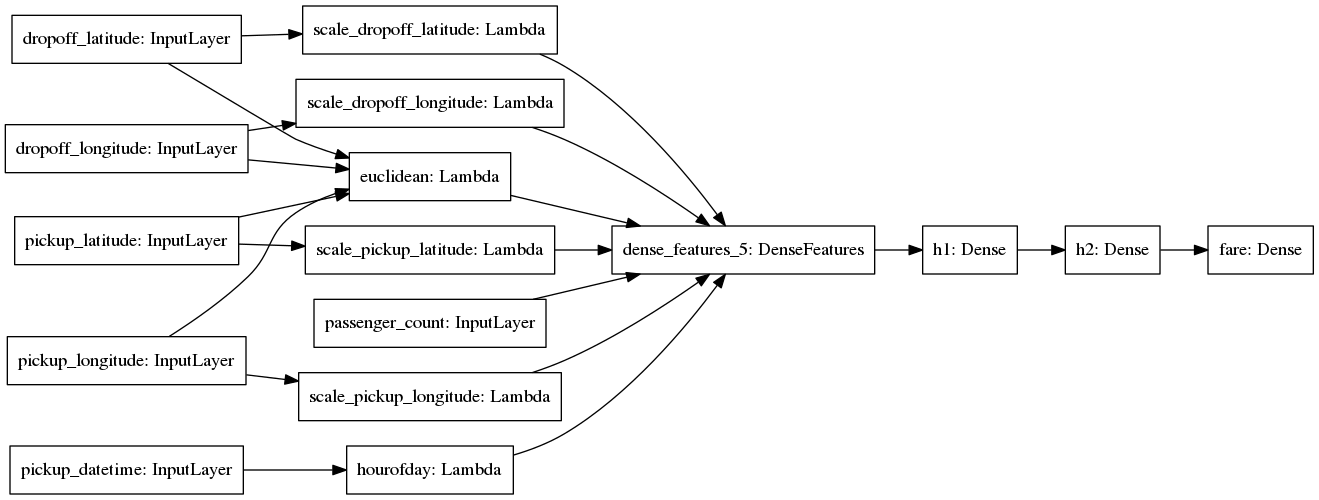

In [31]:
#visualize model
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

#### **Exercise**:   **RUN** the cell below to train the model.

In [32]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 68188 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 10  # how many times to evaluate
NUM_EVAL_EXAMPLES = 17000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)



Epoch 1/10
1065/1065 [==============================] - 29s 27ms/step - loss: 95.0440 - rmse: 9.0962 - mse: 95.0441 - val_loss: 100.3150 - val_rmse: 9.9961 - val_mse: 100.3150
Epoch 2/10
1065/1065 [==============================] - 28s 26ms/step - loss: 61.9961 - rmse: 7.2154 - mse: 61.9961 - val_loss: 43.3989 - val_rmse: 6.5441 - val_mse: 43.3989
Epoch 3/10
1065/1065 [==============================] - 28s 27ms/step - loss: 27.6261 - rmse: 4.2790 - mse: 27.6261 - val_loss: 26.5482 - val_rmse: 5.0798 - val_mse: 26.5482
Epoch 4/10
1065/1065 [==============================] - 26s 25ms/step - loss: 23.8874 - rmse: 4.0144 - mse: 23.8874 - val_loss: 25.6485 - val_rmse: 4.9902 - val_mse: 25.6485
Epoch 5/10
1065/1065 [==============================] - 30s 28ms/step - loss: 25.4860 - rmse: 3.9770 - mse: 25.4860 - val_loss: 25.5260 - val_rmse: 4.9765 - val_mse: 25.5260
Epoch 6/10
1065/1065 [==============================] - 31s 30ms/step - loss: 24.9928 - rmse: 4.0100 - mse: 24.9928 - val_loss: 

#### **Exercise**:   **RUN** the cell to show the model plot.

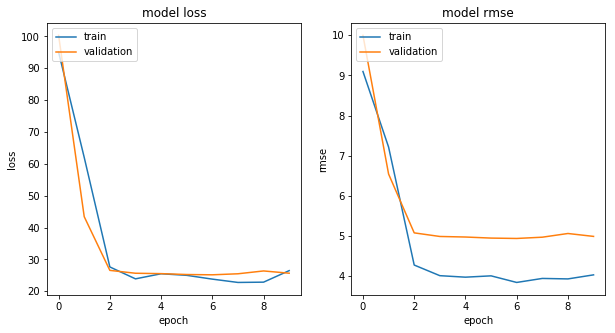

In [33]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Create and test a prediction model


#### **Exercise**:  Create and test a prediction model using the same parameters in Model 3.


In [ ]:
# TO DO - YOUR CODE HERE
# Objective: Create and test a prediction model

In [34]:
# SOLUTION

model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]), 
    'pickup_datetime': tf.convert_to_tensor(['2019-06-03 04:21:29 UTC'], dtype=tf.string),
}, steps=1)


array([[6.3074875]], dtype=float32)

## Lab Summary: 

Our ML problem:  Develop a model to predict taxi fare based on distance -- from one point to another in New York City. Using feature engineering, we were able to predict a taxi fare of $6.30.  The RMSE of 4.035 is based upon the distance travelled.


#### **Exercise**:  Create a RMSE summary table.

####  Markdown table generator:  http://www.tablesgenerator.com/markdown_tables
Create a RMSE summary table:

| Model   | RMSE   | Description                                                               |
|---------|--------|---------------------------------------------------------------------------|
| model_1 | 9.0474 | --Baseline model - no feature engineering                                 |
| model_2 | 9.1769 | --Incorporate pickup_datetime feature                                     |
| model_3 | 4.0946 | --Incorporate Geolocation Features with Bucketization and Feature Crosses |
| model_4 | 4.0345 | --Feature Cross Temporal Features                                         |

#### **Exercise**:   Visualization - Plot a bar chart.

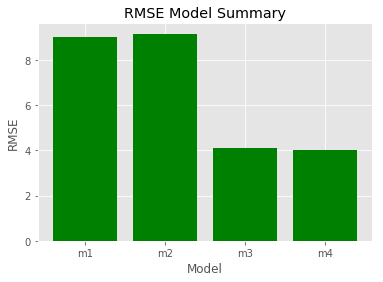

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['m1', 'm2', 'm3', 'm4']
RMSE = [9.04,9.17,4.09,4.035]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, RMSE, color='green')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Model Summary")

plt.xticks(x_pos, x)

plt.show()

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.